🧩 1. Import Libraries and Setup Logging


In [ ]:
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import kagglehub

📁 2. Download and Access the Dataset

In [ ]:
# 📁 Setup Logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

# 📥 Download Dataset
base_path = kagglehub.dataset_download("gunavenkatdoddi/eye-diseases-classification")
DATASET_PATH = os.path.join(base_path, "dataset")
logging.info(f"Subfolders found: {os.listdir(DATASET_PATH)}")


⚙️ 3. Define Constants

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 30
CATEGORIES = ["cataract", "diabetic_retinopathy", "glaucoma", "normal"]


📊 4. Prepare Image Data Generators

In [ ]:
# Apply preprocessing and split the data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

train_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_data = datagen.flow_from_directory(
    DATASET_PATH,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

# Log class names
logging.info(f"Detected classes: {train_data.class_indices}")


Found 3376 images belonging to 4 classes.
Found 841 images belonging to 4 classes.


🧠 5. Load Pretrained VGG19 and Add Custom Layers

In [ ]:
# Load base VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
for layer in base_model.layers[:-4]:
    layer.trainable = False
for layer in base_model.layers[-4:]:
    layer.trainable = True

x = GlobalAveragePooling2D()(base_model.output)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(len(CATEGORIES), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │          65,6

 Total params: 14,780,868 (56.38 MB)

 Trainable params: 7,145,604 (27.26 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

🚀 6. Train the Model

In [ ]:
# ⚖️ Compute Class Weights
y_train = train_data.classes
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

# ⏱️ Callbacks
callbacks = [
    EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)
]

# 🚀 Train Model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=callbacks
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.3211 - loss: 1.4204 - val_accuracy: 0.5898 - val_loss: 1.0045 - learning_rate: 1.0000e-05
Epoch 2/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 766ms/step - accuracy: 0.6284 - loss: 0.9337 - val_accuracy: 0.6671 - val_loss: 0.8394 - learning_rate: 1.0000e-05
Epoch 3/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 81s 769ms/step - accuracy: 0.6805 - loss: 0.7837 - val_accuracy: 0.6980 - val_loss: 0.7721 - learning_rate: 1.0000e-05
Epoch 4/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 80s 757ms/step - accuracy: 0.7314 - loss: 0.7231 - val_accuracy: 0.7015 - val_loss: 0.7522 - learning_rate: 1.0000e-05
Epoch 5/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 79s 747ms/step - accuracy: 0.7765 - loss: 0.6190 - val_accuracy: 0.7122 - val_loss: 0.7163 - learning_rate: 1.0000e-05
Epoch 6/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 773ms/step - accuracy: 0.7859 - loss: 0.5910 - val_accuracy: 0.7432 - val_loss: 0.6458 - learning_rate: 1.0000e-05
Epoch 7/30
106/106 ━━━━━━━━━━━━━━━━━━━━ 82s 770m

🧪 7. Evaluate Model Performance

In [ ]:
# 📊 Evaluate
val_preds = model.predict(val_data)
y_true = val_data.classes
y_pred = np.argmax(val_preds, axis=1)

print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=list(train_data.class_indices.keys())))

27/27 ━━━━━━━━━━━━━━━━━━━━ 15s 485ms/step

Classification Report:

                      precision    recall  f1-score   support

            cataract       0.86      0.88      0.87       207
diabetic_retinopathy       0.90      0.86      0.88       219
            glaucoma       0.68      0.53      0.60       201
              normal       0.61      0.75      0.68       214

            accuracy                           0.76       841
           macro avg       0.76      0.76      0.76       841
        weighted avg       0.77      0.76      0.76       841



🔍 8. Confusion Matrix

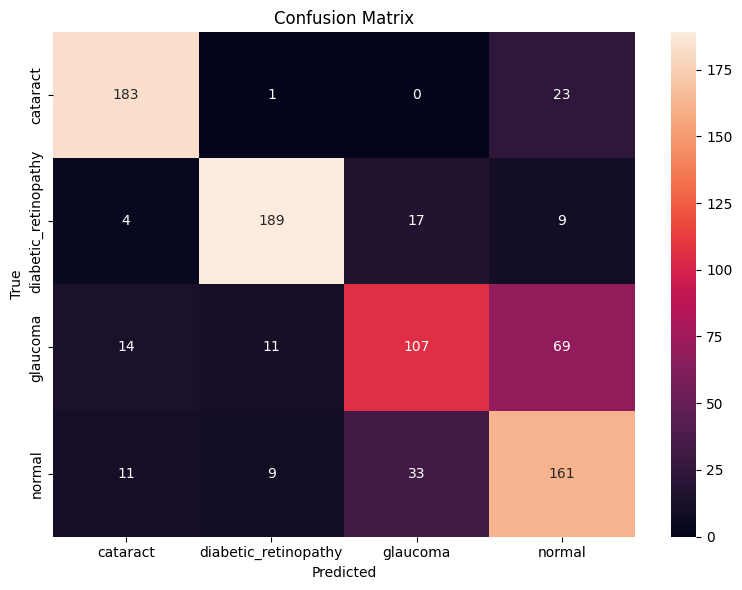

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=CATEGORIES, yticklabels=CATEGORIES)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


📈 10. Accuracy Plot

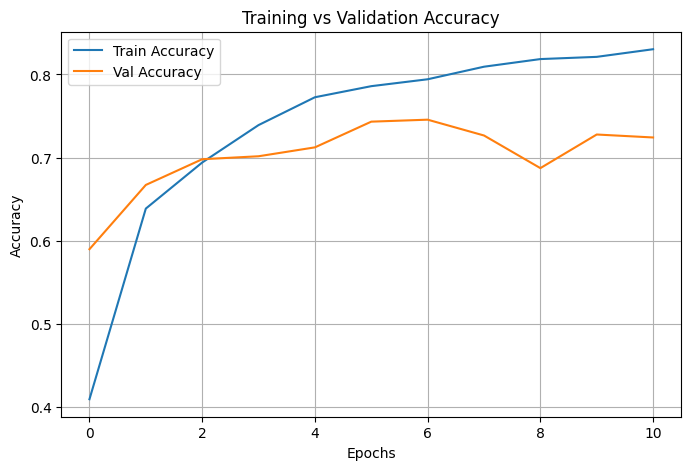

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

💾 9. Save the Trained Model

In [ ]:
os.makedirs("models", exist_ok=True)
model.save("models/eye_disease_model.h5")


In [ ]:
from google.colab import files
files.download("models/eye_disease_model.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>